## Train-Test Split From Scratch

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [3]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [4]:
def train_test_split_verbose(X, y, test_size=0.3):
    """
    Takes in features and labels and returns X_train, X_test, y_train, and y_test
    ----
    In: X (features), y (labels), test_size (percentage of data to go into test)
    Out: X_train, X_test, y_train, and y_test
    """
    X = np.array(X)
    y = np.array(y)
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    splitter = np.random.choice([0,1],size=y.shape,p=[1-test_size,test_size])
    for x,y,z in zip(X,y,splitter):
        if z == 0:
            X_train.append(x)
            y_train.append(y)
        else:
            X_test.append(x)
            y_test.append(y)
    return X_train, X_test, y_train, y_test

In [5]:
from sklearn.datasets import load_boston
X = load_boston().data
y = load_boston().target

In [6]:
X_train, X_test, y_train, y_test = train_test_split_verbose(X,y, test_size=0.2)

In [7]:
len(X_test)/(len(X_train)+len(X_test))

0.2075098814229249

In [8]:
def plot_single_feature_vs_label(X_train, X_test, y_train, y_test, feature_num=0,title="Checking Train-Test Split"):
    x_plot = []
    x_plot_test = []
    for j in X_train:
        x_plot.append(j[feature_num])
    for j in X_test:
        x_plot_test.append(j[feature_num])

    plt.figure(figsize=(8,6))
    plt.scatter(x_plot, y_train, c='b')
    plt.scatter(x_plot_test, y_test, c='r')
    plt.xlabel("Feature " + str(feature_num))
    plt.ylabel("Y");
    plt.title(title);

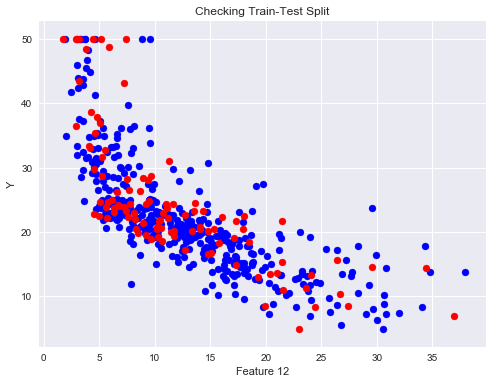

In [9]:
plot_single_feature_vs_label(X_train, X_test, y_train, y_test, feature_num=12)

In [12]:
def train_test_split(X, y, test_size=0.3, seed=None):
    """
    Takes in features and labels and returns X_train, X_test, y_train, and y_test.
    If test_size is a float, it acts as a percentage of data to become test_size.
    If test_size is an int, that many records are returned as a test.
    ----
    In: X (features), y (labels), test_size (percentage of data to go into test), seed
    Out: X_train, X_test, y_train, and y_test
    """
    assert len(X) == len(y), "Length of records and labels must be equal!"

    if isinstance(test_size, float):
        if test_size < 0 or test_size > 1:
            raise ValueError("test_size must be an int, or between 0 and 1")
        test_size = int(len(y)*test_size)
    elif not isinstance(test_size, int):
        raise TypeError("test_size must be an int or a float")

    if seed:
        np.random.seed(seed)

    permute = np.random.permutation(len(y))
    X = X[permute]
    y = y[permute]
    return X[test_size:], X[:test_size], y[test_size:], y[:test_size]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, seed=42)

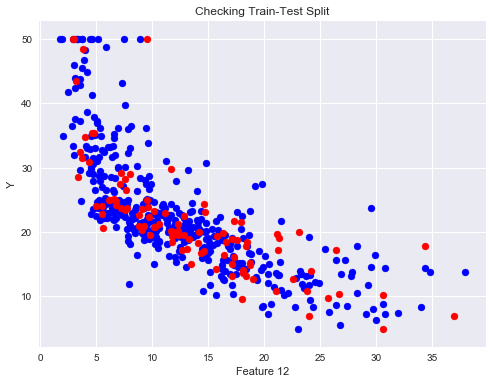

In [18]:
plot_single_feature_vs_label(X_train, X_test, y_train, y_test, feature_num=12)

# Cross Validation from Scratch

In [37]:
class cross_val:
    
    def __init__(self, show_plot=False, feat_num=0):
        """
        The Cross-Val object contains several objects that the user may want to 
        use later, including a final copy of the best model.
        ---
        Params:
        show_plot: should it plot the data showing the splits
        feat_num: if show_plot, which feature should be used (by column num)
        best_model: the model with the lowest MSE is kept for later usage
        """
        self.show_plot = show_plot
        self.feat_num = feat_num
        self.best_model = None
        self.best_model_score = None
        self.coefs = None
        
    def plot_single_feature_vs_label(self, X_train, X_test, y_train, y_test, feature_num=0, 
                                     title="Checking Train-Test Split"):
        """
        This helper method is to make plots of the data being split 
        with one feature vs the target label, showing each fold for 
        visual inspection of the splits. 
        """
        x_plot = []
        x_plot_test = []
        for j in X_train:
            x_plot.append(j[feature_num])
        for j in X_test:
            x_plot_test.append(j[feature_num])

        plt.figure(figsize=(8,6))
        plt.scatter(x_plot, y_train, c='b')
        plt.scatter(x_plot_test, y_test, c='r')
        plt.xlabel("Feature " + str(feature_num))
        plt.ylabel("Y");
        plt.title(title);

    def plot_coefs(self):
        """
        This method shows the coefficient values for each fold in a plot.
        If there are 10 coefficient, there will be 10 plots. If there were 3
        folds, each plot will contain 3 points.
        """
        if not self.coefs:
            print("Either your model doesn't have coefficients, or you")
            print("must run cross_validation_scores first!")
            return            
        for coef in range(len(self.coefs[0])):
            plot_x = []
            plot_y = []
            i=1
            for fold in self.coefs:
                plot_x.append(i)
                plot_y.append(fold[coef])
                i+=1
            plt.figure(figsize=(10,8))
            plt.plot(plot_x,plot_y)
            plt.plot(plot_x,[np.mean(plot_y)]*len(plot_x),'r--')
            plt.ylabel("coef "+str(coef))
            plt.xlabel("Fold ID")
            plt.xticks([x for x in range(1,FOLDS+1)])
            plt.title("Variation of Coefficient Across Folds")
        
    def cross_validation_scores_verbose(self, model, X, y, k=5, random_seed=42):
        """
        Splits the dataset into k folds by randomly assigning each row a
        fold ID. Afterwards, k different models are built with each fold being
        left out once and used for testing the model performance.
        ---
        Inputs:
        model: must be a class object with fit/predict methods. 
        X: feature matrix (array)
        y: labels (array)
        k: number of folds to create and use
        random_seed: sets the random number generator seed for reproducibility
        """
        X = np.array(X)
        y = np.array(y)
        self.score_folds = []
        coefs = []
        fold_nums = [x for x in range(k)]
        np.random.seed(random_seed)
        splitter = np.random.choice(fold_nums,size=y.shape)
        best_score = None
        for fold in fold_nums:
            X_train = []
            X_test = []
            y_train = []
            y_test = []
            for x2,y2,z2 in zip(X,y,splitter):
                if z2 == fold:
                    X_test.append(x2)
                    y_test.append(y2)
                else:
                    X_train.append(x2)
                    y_train.append(y2)
            model.fit(X_train,y_train)
            current_score = model.score(X_test, y_test)
            self.score_folds.append(current_score)
            if not best_score or current_score > best_score:
                best_score = current_score
                self.best_model = model
                self.best_model_score = current_score
            if model.coef_.any():
                coefs.append(model.coef_)
            if self.show_plot:
                plot_title = "CV Fold " + str(fold)
                plot_single_feature_vs_label(X_train, X_test, y_train, y_test, feature_num=self.feat_num, 
                                             title=plot_title)
        if coefs:
            self.coefs = coefs 
            
    def cross_validation_scores(self, model, X, y, k=5, random_seed=42):
        """
        Splits the dataset into k folds by shuffling the data then grabbing
        it section by section - much faster than using for loops to assign IDs. 
        k different models are built with each fold being
        left out once and used for testing the model performance.
        ---
        Inputs:
        model: must be a class object with fit/predict methods. 
        X: feature matrix (array)
        y: labels (array)
        k: number of folds to create and use
        random_seed: sets the random number generator seed for reproducibility
        """
        X = np.array(X)
        y = np.array(y)
        self.score_folds = []
        coefs = []
        fold_nums = [x for x in range(k)]
        np.random.seed(random_seed)
        splitter = np.random.choice(fold_nums,size=y.shape)
        best_score = None
        permute = np.random.permutation(len(y))
        X = X[permute]
        y = y[permute]
        test_size = len(y)//k
        permute = np.random.permutation(len(y))
        for fold in range(k):
            start = fold*test_size
            end = fold*test_size+test_size
            X_test = X[permute[start:end]]
            y_test = y[permute[start:end]]
            X_train = X[~permute[start:end]]
            y_train = y[~permute[start:end]]
            
            model.fit(X_train,y_train)
            current_score = model.score(X_test, y_test)
            self.score_folds.append(current_score)
            if not best_score or current_score > best_score:
                best_score = current_score
                self.best_model = model
                self.best_model_score = current_score
            if model.coef_.any():
                coefs.append(model.coef_)
                self.coefs = coefs 
            if self.show_plot:
                plot_title = "CV Fold " + str(fold)
                plot_single_feature_vs_label(X_train, X_test, y_train, y_test, feature_num=self.feat_num, 
                        title=plot_title)
                    
        
    def print_report(self):
        """
        After the CV has been run, this method will print some summary statistics
        as well as the coefficients from the model.
        """
        print("Mean Score: ", np.mean(self.score_folds))
        print("Score by fold: ", self.score_folds)
        if self.coefs:
            print("Coefs (by fold): ")
            for i,c in enumerate(self.coefs):
                print("Fold ",i,": ",c)

In [38]:
from sklearn.datasets import load_boston
X = load_boston().data
y = load_boston().target

In [51]:
import sys 
sys.path.append('../../modules')
from linear_regression import linear_regression
cv = cross_val()
FOLDS = 10
cv.cross_validation_scores(linear_regression(w_intercept=True), X, y, k=FOLDS)

In [52]:
cv.coefs

[array([[ -1.77872191e-01],
        [  9.25710226e-02],
        [  6.27080472e-02],
        [  9.44888024e+00],
        [ -1.26787608e+01],
        [  1.51987570e-01],
        [ -6.54969619e-02],
        [ -2.58716669e+00],
        [  2.97271045e-01],
        [ -1.31975015e-02],
        [ -6.21836310e-01],
        [  5.97955551e-03],
        [ -6.00840661e-01],
        [  6.03586248e+01]]), array([[  2.59401720e-01],
        [  5.26460199e-02],
        [  4.53693760e-01],
        [  2.20825875e-02],
        [ -2.00405692e+01],
        [  8.46243403e+00],
        [ -6.87921890e-03],
        [ -8.75066511e-01],
        [  3.35279685e-02],
        [ -2.02009570e-02],
        [ -9.77090843e-01],
        [  1.78286033e-02],
        [ -1.52134992e-01],
        [ -2.26540489e-01]]), array([[  4.18326817e-01],
        [  4.30626475e-02],
        [  6.46777835e-03],
        [  2.35298348e-01],
        [ -2.43397683e+01],
        [  6.49275385e+00],
        [ -5.32054580e-02],
        [ -9.73822

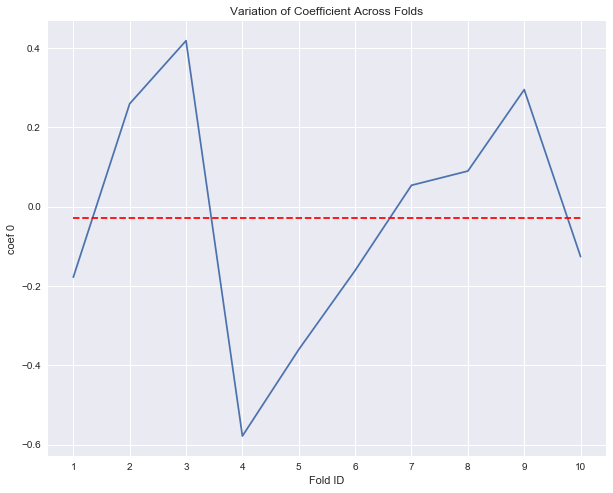

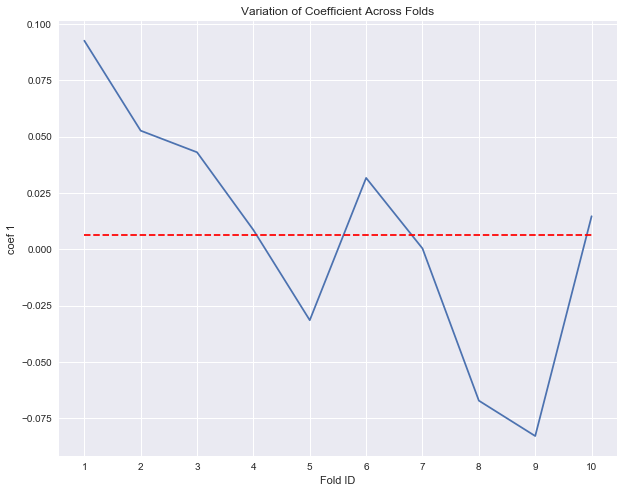

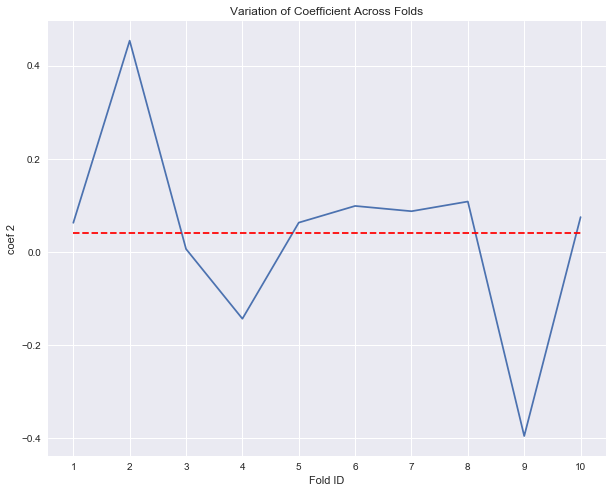

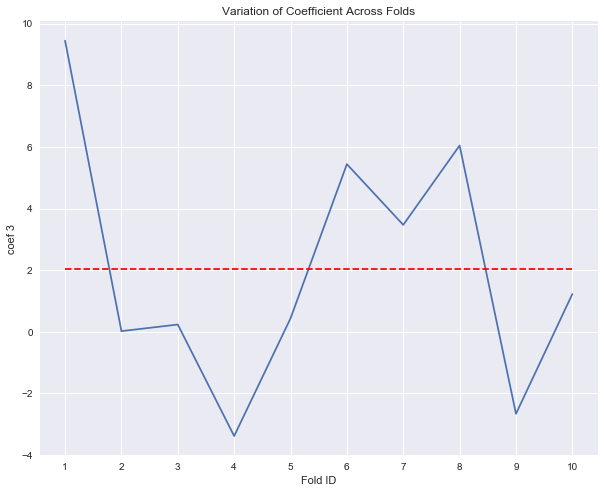

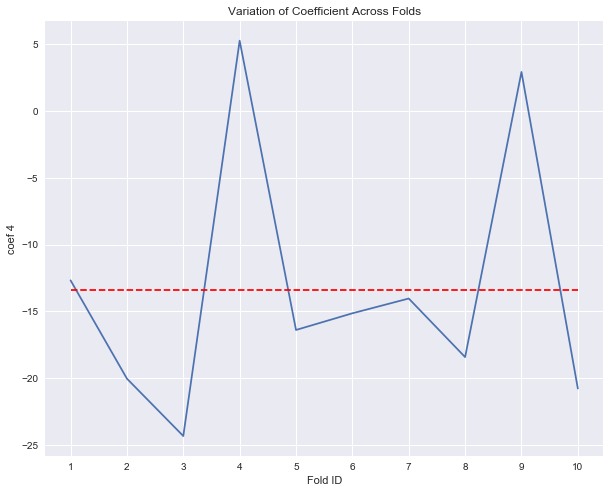

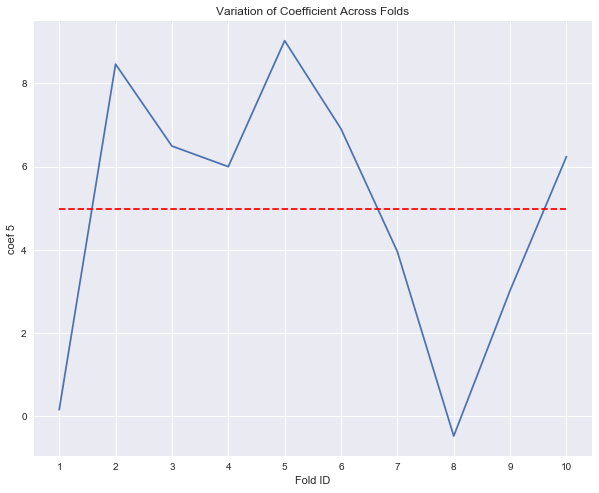

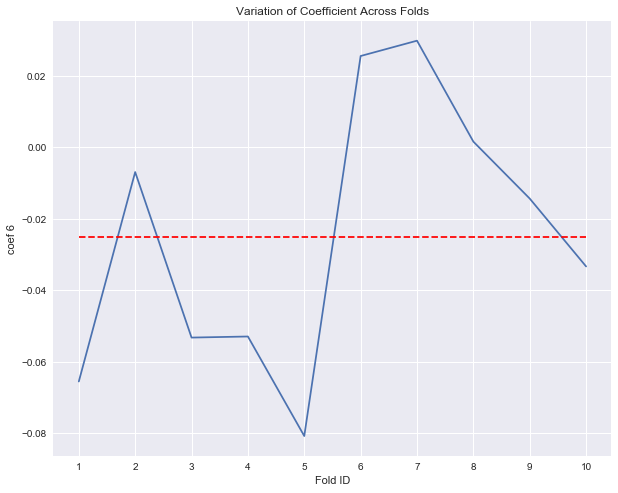

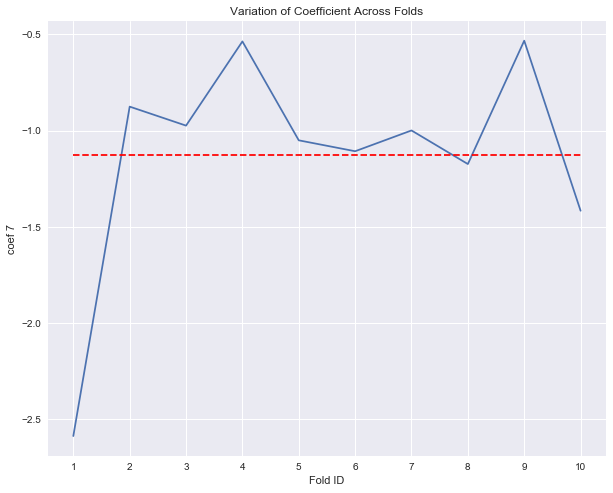

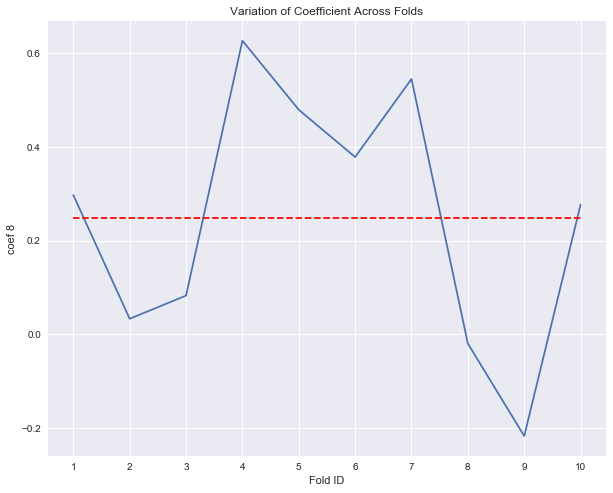

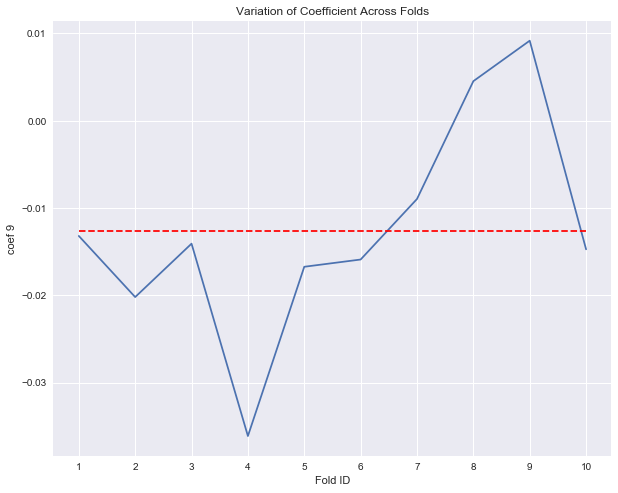

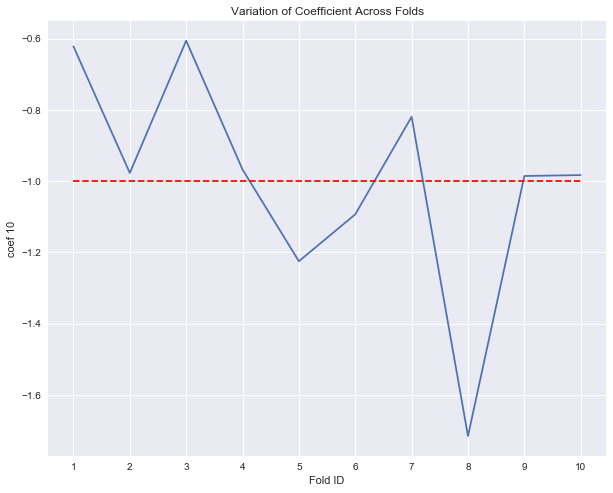

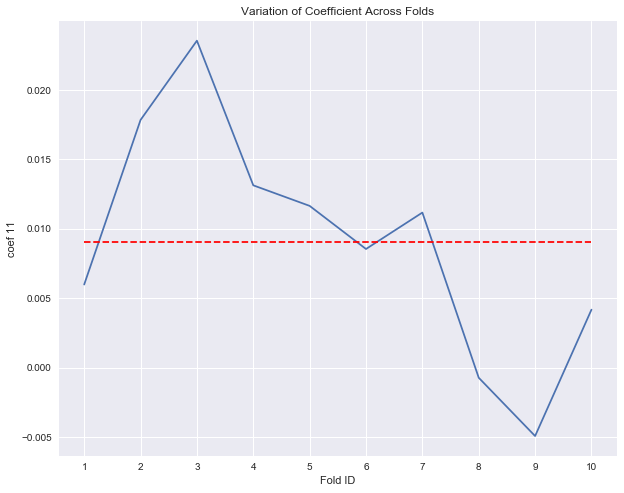

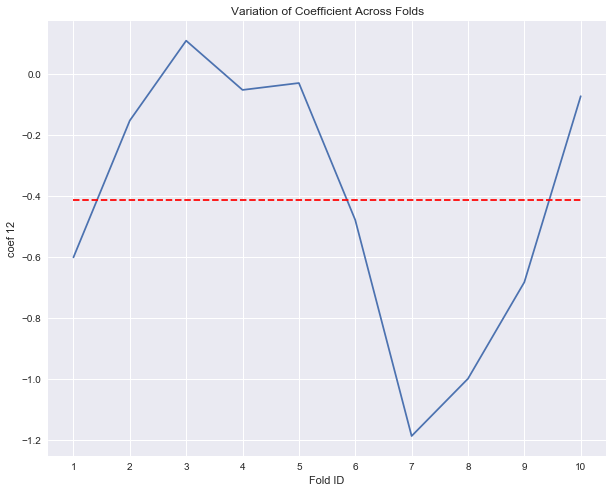

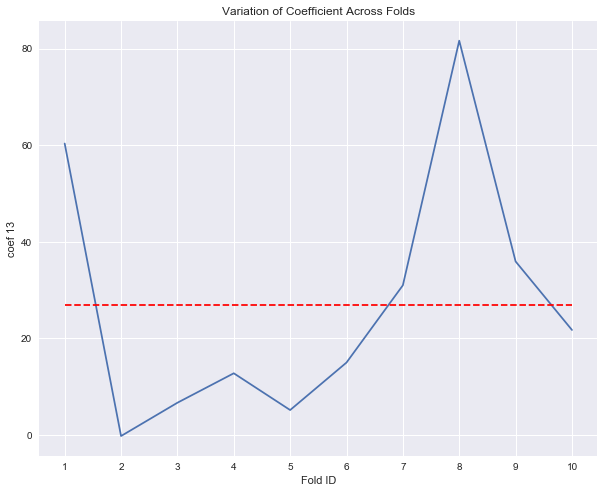

In [53]:
cv.plot_coefs()

In [54]:
cv.print_report()

Mean Score:  -159.260402346
Score by fold:  [-164.25733485025688, -68.742952728538469, -260.34648668910518, -232.32780224516074, -278.23189266072592, -97.265395191265853, -102.54427700942969, -90.813572338605297, -204.0030188167018, -94.071290928050544]
Coefs (by fold): 
Fold  0 :  [[ -1.77872191e-01]
 [  9.25710226e-02]
 [  6.27080472e-02]
 [  9.44888024e+00]
 [ -1.26787608e+01]
 [  1.51987570e-01]
 [ -6.54969619e-02]
 [ -2.58716669e+00]
 [  2.97271045e-01]
 [ -1.31975015e-02]
 [ -6.21836310e-01]
 [  5.97955551e-03]
 [ -6.00840661e-01]
 [  6.03586248e+01]]
Fold  1 :  [[  2.59401720e-01]
 [  5.26460199e-02]
 [  4.53693760e-01]
 [  2.20825875e-02]
 [ -2.00405692e+01]
 [  8.46243403e+00]
 [ -6.87921890e-03]
 [ -8.75066511e-01]
 [  3.35279685e-02]
 [ -2.02009570e-02]
 [ -9.77090843e-01]
 [  1.78286033e-02]
 [ -1.52134992e-01]
 [ -2.26540489e-01]]
Fold  2 :  [[  4.18326817e-01]
 [  4.30626475e-02]
 [  6.46777835e-03]
 [  2.35298348e-01]
 [ -2.43397683e+01]
 [  6.49275385e+00]
 [ -5.3205458

In [55]:
cv.best_model.predict(X[0].reshape(-1,13))

26.23656289367716

In [56]:
print(cv.best_model)
print(cv.best_model_score)

-68.7429527285


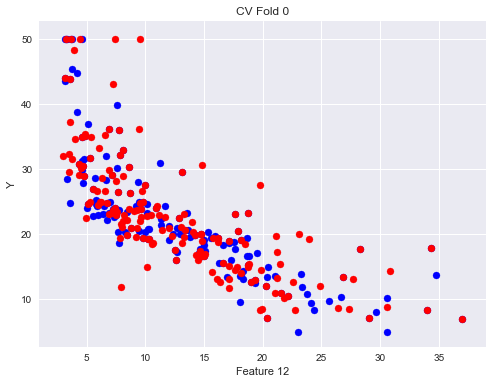

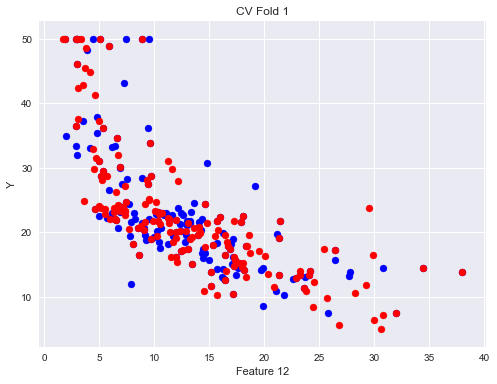

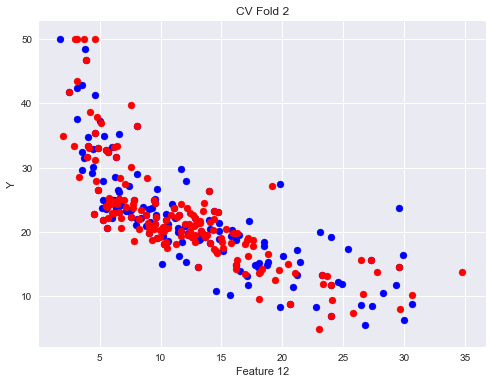

In [57]:
cv = cross_val(show_plot=True, feat_num=12)
cv.cross_validation_scores(linear_regression(), X, y, k=3)